In [1]:
%matplotlib widget
import numpy as np
import obspy
import io
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
import datetime
from datetime import timezone
import types
import pickle
from location.compute_backazimuths import compute_backazimuths, calculate_event_baz
from location.single_event_backazimuth import compute_backazimuths as single_event_backazimuth
from figures.figures import plot_catalog_and_big_event_backazimuths, plot_big_event_backazimuths, transform_imagery, get_station_coordinates, get_station_grid_locations

In [ ]:
'''

Manually pick events that occur within the time window constrained by imagery

'''

# get data
st = obspy.read("data/MSEED/may_8-11_velocity_100000s_downsampled.MSEED")

# set low cut periods of data to be dispayed
freq = [10,100,1000]

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8,10,18)
window_end = obspy.UTCDateTime(2012,5,11,3,13)
data_dict = {}
for tr in st:
    for f in freq: 
        key = tr.stats.station+tr.stats.channel+str(f)
        st_filt = tr.copy().filter("highpass",freq=1/f)
        data_dict[key] = st_filt.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_filt.times(type="matplotlib")
    
# make plot
nrows = len(freq)
fig,ax = plt.subplots(nrows,1,figsize=[15,10])
plt.subplots_adjust(bottom=0.2)

# plot the data
for i in range(nrows):
    ax[i].plot(t,data_dict["PIG2HHZ"+str(freq[i])], lw=2,color='k')
    ax[i].set_title("PIG2 HHZ\n\n>"+str(freq[i])+"s",y=0.8)
    ax[i].set_ylabel("Velocity (mm/s)")
    ax[i].set_xlabel("Time")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M:%S'))
    ax[i].set_xlim([t[0],t[-1]])
    ax[nrows-1].get_shared_x_axes().join(ax[nrows-1],ax[i])

# define object for updating data when buttons are pressed
class metadata:
    def __init__(self,station,channel):
        self._station = station
        self._channel = channel

    def select_component(self,component_id,component_type):
        def clicked(event):
            if component_type == "station":
                self._station = component_id
            if component_type == "channel":
                self._channel = component_id
            for i in range(nrows):
                key = self._station+self._channel+str(freq[i])
                ax[i].get_lines()[0].set_ydata(data_dict[key])
                ax[i].relim()
                ax[i].autoscale()
                ax[i].set_xlim([t[0],t[-1]])
                ax[i].set_title(self._station+" "+self._channel+"\n\n>"+str(freq[i])+"s",y=0.8)
            plt.draw()
        return clicked
    
def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))

# take care of arrival time storage
cid = fig.canvas.mpl_connect('button_press_event', mouse_event)
    
# make instances of the widget
column0 = metadata("PIG2","HHZ")  

# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_component("PIG2","station"))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_component("PIG4","station"))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_component("PIG5","station"))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_component("HHZ","channel"))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_component("HHN","channel"))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_component("HHE","channel"))
plt.text(-4,0.4,"Channels")

# make pick handling
class picks:
    start_time = []
    end_time = []
    event_windows = []
    def picker(self):
        def clicked(event):
            if plt.get_current_fig_manager().toolbar.mode != '': return
            if event.button == 1:
                self.start_time = matplotlib.dates.num2date(event.xdata)
                for axis in ax:
                    axis.axvline(event.xdata,0,1,color ='g',linestyle='--')
            if event.button == 3:
                self.end_time = matplotlib.dates.num2date(event.xdata)
                self.event_windows.append([self.start_time,self.end_time])
                for axis in ax:
                    axis.axvline(event.xdata,0,1,color ='r',linestyle='--')
                np.save('outputs/detections_new.npy',self.event_windows,allow_pickle=True)
        return clicked
    
detections = picks()
cid = fig.canvas.mpl_connect('button_press_event', detections.picker())

plt.show()

In [ ]:
''' 

Calculate backazimuths for all manually picked events

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.win_len = 20
l.slide = 5
l.stations = ["PIG2","PIG4","PIG5"]
l.network = "XC"

# load and sort catalog
detection_times = np.load('outputs/detections.npy',allow_pickle=True)
sort_indices = np.argsort(detection_times[:,0])
l.detection_times = detection_times[sort_indices]

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,10]
l.fs = 100

# specify paths to data and me tadata
#l.data_path = "data/MSEED/no_IR/"
#l.xml_path = "data/XML/"
l.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
l.xml_path = "/media/Data/Data/PIG/XML/HH/"
l.filename = "outputs/event_backazimuths_" + '_'.join(l.stations) + "_" + l.pca_correction + "_pca_" + l.centroid + "_centroid"
l.n_procs = 10

# run the backazimuth code
b = compute_backazimuths(l)

# save the output
baz_file = open(l.filename + ".pickle", "wb")
pickle.dump(b, baz_file)
baz_file.close()

In [ ]:
'''

Plot the locations of all the detected events

'''

# load the results of polarization analysis
baz_file = open("outputs/event_backazimuths_PIG2_PIG4_PIG5_distance_pca_fixed_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# get backazimuths of detected events
backazimuths = b.backazimuths
big_event_backazimuth = backazimuths[14]

# get station locations and array centroids
station_lon_lat_coords = get_station_coordinates("data/XML/")
station_grid_coords = get_station_grid_locations(station_lon_lat_coords,"epsg:3245")
array_centroid = np.mean(station_grid_coords,axis=0)

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
transform_imagery(file,'epsg:3245')

# set where to split the distribution and which color to use for each
colors = ["#7570b3","#d95f02"]

# make the figure
plot_catalog_and_big_event_backazimuths(backazimuths,big_event_backazimuth,array_centroid,station_grid_coords,colors)

In [ ]:
'''

Investigate which events are coming from the azimuthal range of the new rift branch

'''

# load catalog 
detection_times = np.load('outputs/detections.npy',allow_pickle=True)

# read backazimuths
baz_file = open("outputs/event_backazimuths_PIG2_PIG4_PIG5_distance_pca_fixed_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
backazimuths = b.backazimuths

# set range of interest
baz_range = [280,360]

# get data
st = obspy.read("data/MSEED/may_8-11_velocity_100000s_downsampled.MSEED")

# set low cut periods of data to be dispayed
freq = [10,100,1000]

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8,10,18)
window_end = obspy.UTCDateTime(2012,5,11,3,13)
data_dict = {}
for tr in st:
    for f in freq: 
        key = tr.stats.station+tr.stats.channel+str(f)
        st_filt = tr.copy().filter("highpass",freq=1/f)
        data_dict[key] = st_filt.trim(starttime=window_start,endtime=window_end).data*1000

# get time vector
t = st_filt.times(type="matplotlib")

# make plot
nrows = len(freq)
fig,ax = plt.subplots(nrows,1,figsize=[15,10])
plt.subplots_adjust(bottom=0.2)

# plot the data
for i in range(nrows):
    ax[i].plot(t,data_dict["PIG2HHZ"+str(freq[i])], lw=2,color='k')
    ax[i].set_title("PIG2 HHZ\n\n>"+str(freq[i])+"s",y=0.8)
    ax[i].set_ylabel("Velocity (mm/s)")
    ax[i].set_xlabel("Time")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%H:%M:%S'))
    ax[i].set_xlim([t[0],t[-1]])
    ax[nrows-1].get_shared_x_axes().join(ax[nrows-1],ax[i])

# define object for updating data when buttons are pressed
class metadata:
    def __init__(self,station,channel):
        self._station = station
        self._channel = channel

    def select_component(self,component_id,component_type):
        def clicked(event):
            if component_type == "station":
                self._station = component_id
            if component_type == "channel":
                self._channel = component_id
            for i in range(nrows):
                key = self._station+self._channel+str(freq[i])
                ax[i].get_lines()[0].set_ydata(data_dict[key])
                ax[i].relim()
                ax[i].autoscale()
                ax[i].set_xlim([t[0],t[-1]])
                ax[i].set_title(self._station+" "+self._channel+"\n\n>"+str(freq[i])+"s",y=0.8)
            plt.draw()
        return clicked
    
def mouse_event(event):
    print('x: {} and y: {}'.format(event.xdata, event.ydata))
    
# make instances of the widget
column0 = metadata("PIG2","HHZ")

# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_component("PIG2","station"))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_component("PIG4","station"))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_component("PIG5","station"))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_component("HHZ","channel"))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_component("HHN","channel"))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_component("HHE","channel"))
plt.text(-4,0.4,"Channels")

# highlight events in baz range of interest
for i in range(len(backazimuths)):
    if backazimuths[i] >= baz_range[0] and backazimuths[i] <= baz_range[1]:
        for axis in ax:
            axis.axvline(detection_times[i][0],0,1,color ='g',linestyle='--')
            axis.axvline(detection_times[i][1],0,1,color ='r',linestyle='--')

plt.show()

In [ ]:
'''

Investigate relationships between frequency and duration, SNR, and amplitude

'''

# set parameters 
big_event_index = 14
station = "PIG2"
channels = ["HHZ","HHE","HHN"]
freq = [1,10,100,1000,10000]
fs = 100
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
# load and sort catalog
detection_times = np.load('outputs/detections.npy',allow_pickle=True)
sort_indices = np.argsort(detection_times[:,0])
detection_times = detection_times[sort_indices]
    
# get data using workaround for reading large MSEED files with obspy
st = obspy.Stream()
with io.open("data/MSEED/may_8-11_velocity_100000s.MSEED", "rb") as fh:
    while True:
        with io.BytesIO() as buf:
            c = fh.read(512*1000000)
            if not c:
                break
            buf.write(c)
            buf.seek(0, 0)
            st += obspy.read(buf)
st.merge()

# put data into dictionary
window_start = obspy.UTCDateTime(2012,5,8,10,18)
window_end = obspy.UTCDateTime(2012,5,11,3,13)
big_event_window_end = [obspy.UTCDateTime(2012,5,9,18,10),obspy.UTCDateTime(2012,5,9,18,10),obspy.UTCDateTime(2012,5,9,18,40),
              obspy.UTCDateTime(2012,5,9,20),obspy.UTCDateTime(2012,5,9,20),obspy.UTCDateTime(2012,5,9,20)]
data_dict = {}
for tr in st:
    for f in freq: 
        key = tr.stats.station+tr.stats.channel+str(f)
        st_filt = tr.copy().filter("highpass",freq=1/f)
        data_dict[key] = st_filt.trim(starttime=window_start,endtime=window_end).data*1000

# make functions that estimate each parameter of interest
def get_duration(data):
    cumulative_curve = np.cumsum(np.square(data))
    max_curve = np.max(cumulative_curve)
    finish_amp = 0.95 * max_curve
    duration = len(np.where((cumulative_curve<=finish_amp))[0])/fs
    return duration

def get_snr(data):
    snr = get_amplitude(data)/data.std()
    return snr

def get_amplitude(data):
    amplitude = np.max(np.abs(data))
    return amplitude

def regression(model_vector,data_vector):
    model_vector = np.vstack((np.array(model_vector),np.ones((len(model_vector))))).transpose()
    m,b = np.linalg.lstsq(model_vector,data_vector,rcond=None)[0]
    return m,b

# make plot 
fig,ax = plt.subplots(3,3,figsize=[12,10])
for axes in ax:
    for axis in axes:
        axis.set_xscale('log')
for axes in ax[:2]:
    for axis in axes:
        axis.set_yscale('log')
        
# iterate through each channel 
for c in range(len(channels)):
    for i in range(len(detection_times)):
        duration_vector = []
        amplitude_vector = []
        snr_vector = []
        for f in range(len(freq)):
               
            # get correct trace
            data = data_dict[station+channels[c]+str(freq[f])]
            
            # trim to just event window
            if i == big_event_index:
                duration_to_start = detection_times[i][0] - st.trim(starttime=window_start,endtime=window_end)[0].stats.starttime.datetime.replace(tzinfo=timezone.utc)
                duration_to_end = big_event_window_end[f].datetime - st.trim(starttime=window_start,endtime=window_end)[0].stats.starttime.datetime
            else:  
                duration_to_start = detection_times[i][0] - st.trim(starttime=window_start,endtime=window_end)[0].stats.starttime.datetime.replace(tzinfo=timezone.utc)
                duration_to_end = detection_times[i][1] - st.trim(starttime=window_start,endtime=window_end)[0].stats.starttime.datetime.replace(tzinfo=timezone.utc)
            start_index = fs * (duration_to_start.days*86400+duration_to_start.seconds)
            end_index = fs * (duration_to_end.days*86400+duration_to_end.seconds)
            data_trim = data[start_index:end_index]
            
            # estimate each parameter
            duration = get_duration(data_trim)
            amplitude = get_amplitude(data_trim)           
            snr = get_snr(data_trim)           
            
            # make scatter plot
            if i == big_event_index:
                color = colors[1]
            else:
                color = colors[0]
                amplitude_vector.append(amplitude)
                duration_vector.append(duration)
                snr_vector.append(snr)
            duration_point = ax[0][c].scatter(1/freq[f],duration,color=color)
            amplitude_point = ax[1][c].scatter(1/freq[f],amplitude,color=color)
            snr_point = ax[2][c].scatter(1/freq[f],snr,color=color)
                
        # plot a best fit line for each set of scattered values
        #[m,b] = regression(np.log10(np.array(low_cut)),np.log10(duration_vector))
        #ax[0][c].plot(low_cut,10**(m*np.log10(np.array(low_cut))+b),'--',color=colors[0],alpha=0.25)
        #[m,b] = regression(np.log10(np.array(low_cut)),np.log10(amplitude_vector))
        #ax[1][c].plot(low_cut,10**(m*np.log10(np.array(low_cut))+b),'--',color=colors[0],alpha=0.25)

ax[0][0].set_title('HHZ')
ax[0][1].set_title('HHN')
ax[0][2].set_title('HHE')
ax[0][0].set_ylabel('Duration (s)')
ax[1][0].set_ylabel('Max amplitude (m/s)')
ax[2][0].set_ylabel('SNR')
for axis in ax[0]:
    #axis.set_ylim([10**2,10**4])
    axis.set_xticks([1e-4,1e-3,1e-2,1e-1,1])
for axis in ax[1]:
    #axis.set_ylim([10**(-5),10**(-2.5)])
    axis.set_xticks([1e-4,1e-3,1e-2,1e-1,1])
for axis in ax[2]:
    #axis.set_ylim([2,10])
    axis.set_xlabel('Low cutoff frequency (Hz)')
    axis.set_xticks([1e-4,1e-3,1e-2,1e-1,1])
plt.show()

In [19]:
''' 

Calculate backazimuth through time for big event

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()
l.all_stations = ["PIG2","PIG4","PIG5"]
l.stations = ["PIG5"]
l.network = "XC"
l.fs = 100

# set event start time
event_start = datetime.datetime(2012, 5, 9, 18, tzinfo=datetime.timezone.utc)
event_end = datetime.datetime(2012, 5, 9, 20, tzinfo=datetime.timezone.utc)
l.detection_times = np.array([[event_start,event_end]])

# manually set first arrival (needs to be done manually if using a single station- only use to look at backazimuth through time for an event with known first arrival)
l.first_stat = "PIG2"

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations and sta/lta ratio for throwing out individual windows in backazimuth computation
l.snr_threshold = 0
l.stalta_threshold = 0

# specify method for correcting pca components 
l.pca_correction = "distance"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000

# specify paths to data and me tadata
l.data_path = "/media/Data/Data/PIG/MSEED/noIR/"
l.xml_path = "/media/Data/Data/PIG/XML/HH/"
l.n_procs = 10

# run the backazimuth code
periods = [1,10,100,1000]
for p in range(len(periods)):
    
    # change freqeuncy band
    l.freq = [1/periods[p],49]
    
    # set parameters based on low cut frequency
    l.win_len = periods[p]/10
    l.slide = l.win_len
    l.filename = "outputs/big_event_backazimuth_" + '_'.join(l.stations) + "_" + str(l.freq[0]) + "-" + str(l.freq[1])+"Hz"
    
    # run polarization analysis
    b = single_event_backazimuth(l)

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09

Got all files...

Made inputs...

Finished with 2012-05-09



In [20]:
def baz_hist(periods,win_lens,moving_win_lens,total_len,stations):
    fig,ax = plt.subplots(len(periods),2,figsize=(15,15),subplot_kw={'projection':'polar'})
    for p in range(len(periods)):

        # change freqeuncy band
        freq = [1/periods[p],49]

        # set parameters based on low cut frequency
        moving_win_len_ind = int(moving_win_lens[p]/win_lens[p])
        total_len_ind = int(total_len/win_lens[p])

        # read file
        baz_file = open("outputs/big_event_backazimuth_" + '_'.join(stations) + "_" + str(freq[0]) + "-" + str(freq[1])+"Hz.pickle", "rb")
        b = pickle.load(baz_file)
        baz_file.close()

        # calculate backazimths for each window
        baz = []
        for pca in b.all_windows_backazimuths[0][:total_len_ind]:
            if np.sum(pca) != 0:
                baz.append(calculate_event_baz(np.array([pca]),np.array([1])))
            else:
                baz.append(np.nan)

        mov_mean = []
        indices = range(0,int(total_len_ind+moving_win_len_ind),int(moving_win_len_ind))
        for i in range(len(indices)-1):
            if np.sum(b.all_windows_backazimuths[0][indices[i]:indices[i+1]]) != 0:
                pca_mean = np.nanmean(b.all_windows_backazimuths[0][indices[i]:indices[i+1]],axis=0)
                mov_mean.append(calculate_event_baz(np.array([pca_mean]),np.array([1])))
            else:
                mov_mean.append(np.nan)

        # set yticks for both plots in seconds
        yticks = [0,900,1800,2700,3600,4500,5400,6300,7200]
        yticklabels = ["18:00","18:15","18:30","18:45","19:00","19:15","19:30","19:45","20:00",]

        # make plots
        ax[p][0].scatter(np.array(baz)/180*np.pi,range(len(baz)),marker='o',s=0.5)
        ax[p][0].set_theta_direction(-1)
        ax[p][0].set_theta_zero_location("N")
        ax[p][0].set_title(">" + str(freq[0]) + "Hz (" + str(win_lens[p]) + "s window)")
        ax[p][0].set_yticks(np.array(yticks)/win_len)
        ax[p][0].set_yticklabels(yticklabels)
        ax[p][1].scatter(np.array(mov_mean)/180*np.pi,range(len(mov_mean)),marker='o',s=0.5)
        ax[p][1].set_theta_direction(-1)
        ax[p][1].set_theta_zero_location("N")
        ax[p][1].set_title(">" + str(freq[0]) + "Hz (" + str(win_lens[p]) + "s window with " + str(moving_win_lens[p]) + "s moving average)")
        ax[p][1].set_yticks(np.array(yticks)/moving_win_lens[p])
        ax[p][1].set_yticklabels(yticklabels)
        plt.suptitle("Backazimuths through time computed using " +" ".join(stations)+'\n')
    plt.show()
    plt.tight_layout()

NameError: name 'win_len' is not defined

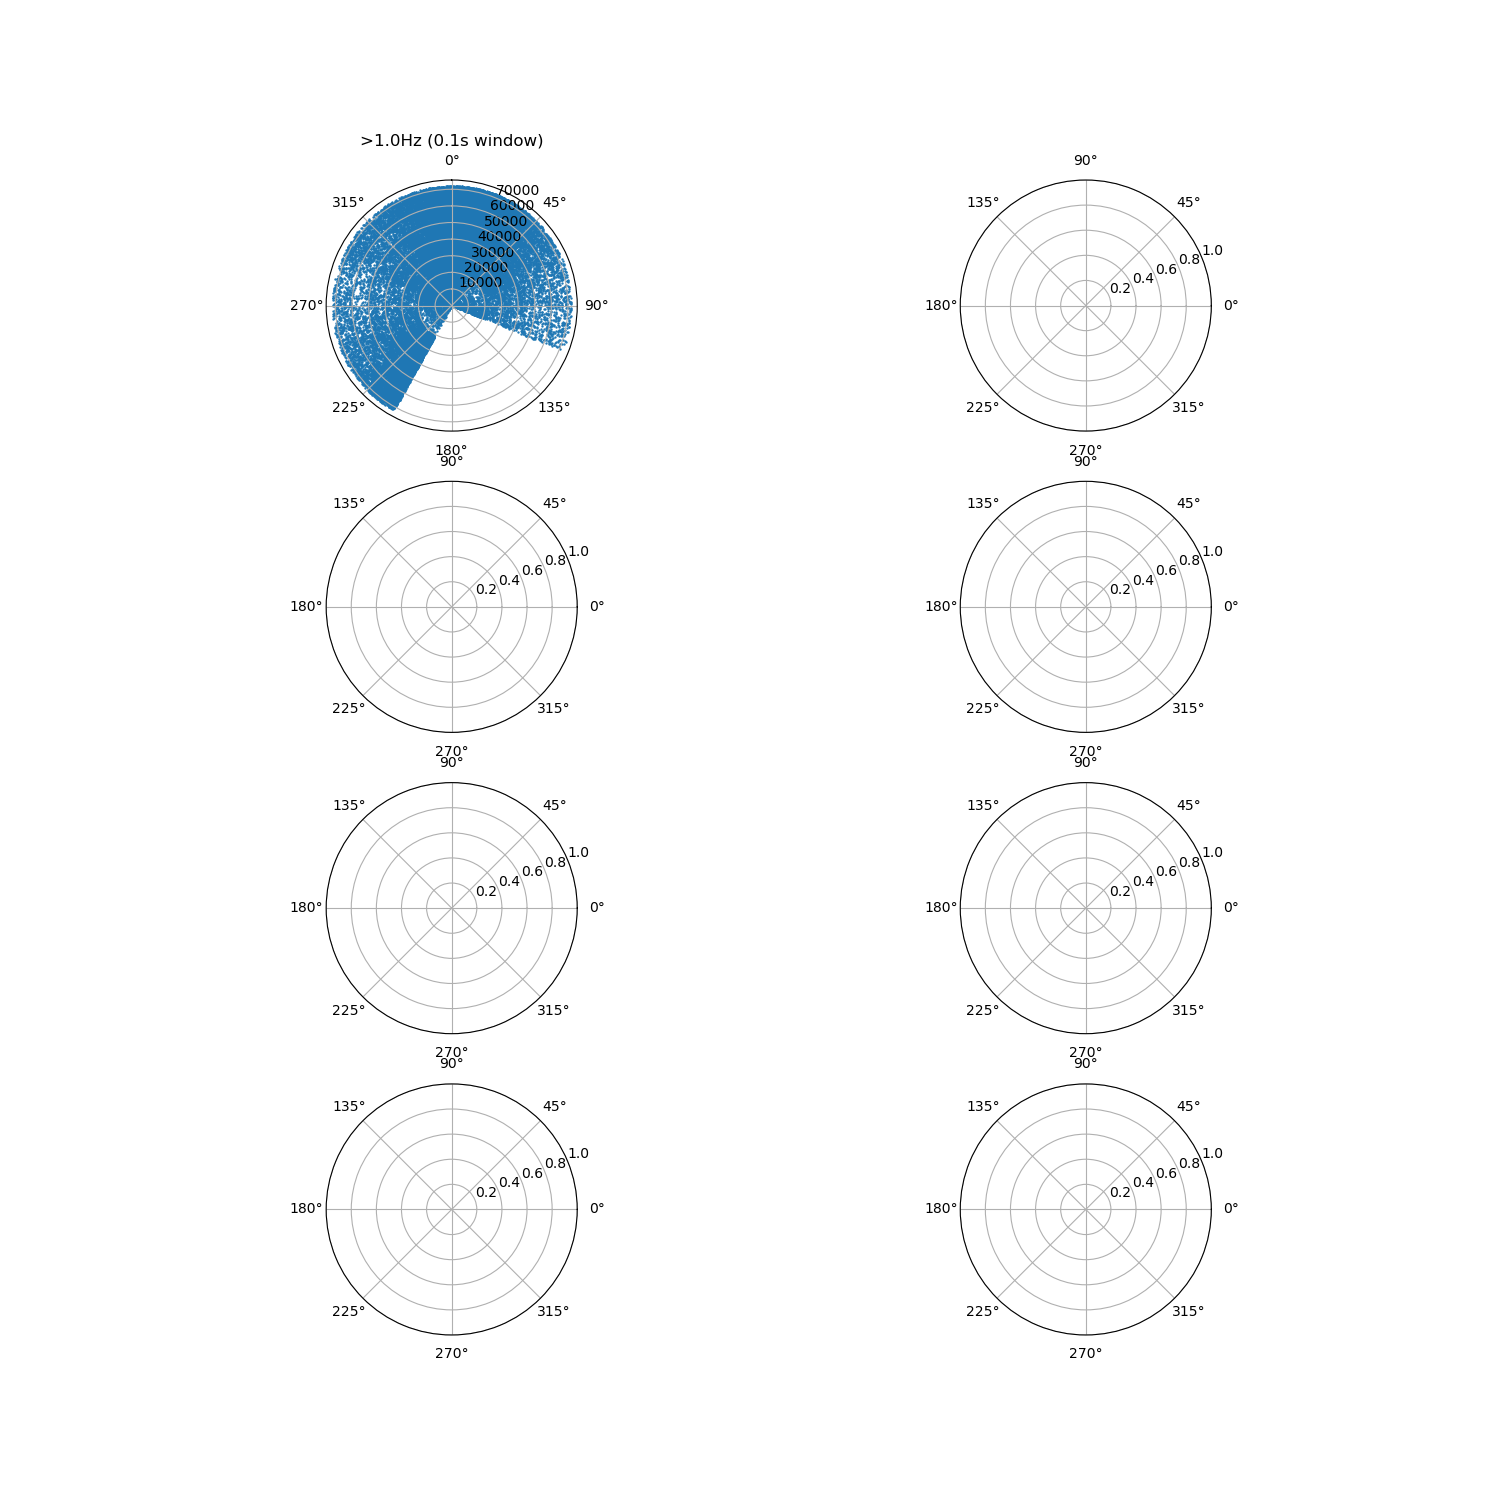

In [21]:
# set the range of periods to be included (in log10)
periods = [1,10,100,1000]
win_lens = [0.1,1,10,100]
moving_avg_lens = [1,10,100,1000]
total_len = 7200
stations = ["PIG2"]
baz_hist(periods,win_lens,moving_avg_lens,total_len,["PIG2"])
baz_hist(periods,win_lens,moving_avg_lens,total_len,["PIG4"])
baz_hist(periods,win_lens,moving_avg_lens,total_len,["PIG5"])
baz_hist(periods,win_lens,moving_avg_lens,total_len,["PIG2","PIG4","PIG5"])